## Human pose estimation   

* Zhe Cao, Tomas Simon, Shih-En Wei, and Yaser Sheikh
* Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields.   CVPR 20177
* This notebook is based on: https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation


```
# look at https://modelzoo.co/model/keras-realtime-multi-person-pose-estimation
!git clone https://github.com/asabuncuoglu13/keras-openpose-reproduce.git
!mv keras-openpose-reproduce/* ./    &&    mkdir model/keras       
!cd model   && sh get_keras_model.sh
!pip3 -q install Cython scikit-image pandas zmq h5py opencv-python configobj
 ```


In [80]:
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda, Concatenate, BatchNormalization, Conv2D, MaxPooling2D
from openpose_utils.config_reader import config_reader
import scipy
import math
import os

In [92]:
base_path = "C:\\Users\\ASABUNCUOGLU13\\Documents\\data\\code\\keras-openpose-reproduce"
input_image_path = "C:\\Users\\ASABUNCUOGLU13\\Documents\\data\\vol02\\td-slices-group\\frames-%d"
output_features_path = "C:\\Users\\ASABUNCUOGLU13\\Documents\\data\\vol02\\td-slices-group\\pose-features\\%d\\%s\\peaks.npy"

In [ ]:
for ind in range(19):
    !mkdir {output_features_path % ind}

### Definition of model

Helper functions to create a model.  These are the individual blocks.

In [83]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

![openpose architecture](https://github.com/ZheC/Multi-Person-Pose-Estimation/raw/master/readme/arch.png)

Create keras model by assembling the blocks and load the pretrained weights.

In [84]:
weights_path = "model\\keras\\model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(os.path.join(base_path, weights_path))

### Applying the model to an image

Load a sample image

In [85]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import openpose_utils.util as util

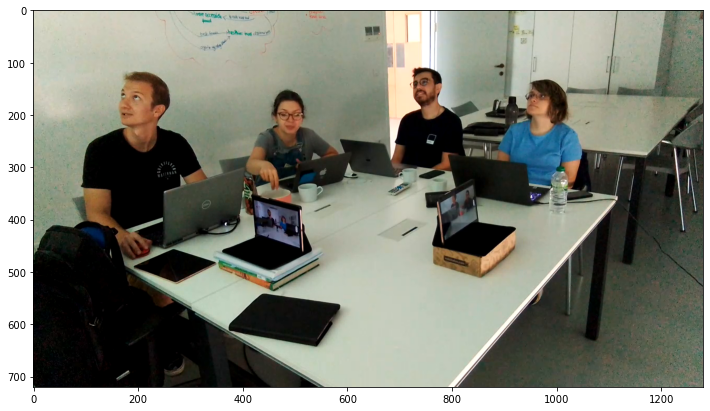

In [99]:
test_image = os.path.join(input_image_path % 0, "f5.png")
oriImg = cv2.imread(test_image) # B,G,R order
plt.figure(figsize=(12,12))
plt.imshow(oriImg[:,:,[2,1,0]])

Load configuration

In [87]:
param, model_params = config_reader('openpose_utils/config')

multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
print ('scale factors for this image:', multiplier)

scale factors for this image: [0.25555555555555554, 0.5111111111111111, 0.7666666666666667, 1.0222222222222221]


### Detect the body parts (keypoints) in the heat maps and visualize them

Visualise all detected body parts. Note that we use peaks in heatmaps

In [ ]:
from scipy.ndimage.filters import gaussian_filter

for i in range(1):
    images = Path(input_image_path % i).glob('*.png')

    for test_image in images:
        filename = os.path.basename(test_image)
        filename = os.path.splitext(filename)[0]

        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
            axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
            axarr[m].set_title('Input image: scale %d' % m)

            input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
            output_blobs = model.predict(input_img)
            
            # extract outputs, resize, and remove padding
            heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
            heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
            
            paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
            paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
            paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
            paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
                
            heatmap_avg = heatmap_avg + heatmap / len(multiplier)
            paf_avg = paf_avg + paf / len(multiplier)


        all_peaks = []
        peak_counter = 0

        for part in range(19-1):
            map_ori = heatmap_avg[:,:,part]
            map = gaussian_filter(map_ori, sigma=3)
            
            map_left = np.zeros(map.shape)
            map_left[1:,:] = map[:-1,:]
            map_right = np.zeros(map.shape)
            map_right[:-1,:] = map[1:,:]
            map_up = np.zeros(map.shape)
            map_up[:,1:] = map[:,:-1]
            map_down = np.zeros(map.shape)
            map_down[:,:-1] = map[:,1:]
            
            peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
            peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
            peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
            id = range(peak_counter, peak_counter + len(peaks))
            peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

            all_peaks.append(peaks_with_score_and_id)
            peak_counter += len(peaks)

        with open(output_features_path % (0, filename), 'wb') as f:
            np.save(f, {p[0]:p[1] for p in enumerate(all_peaks)}, allow_pickle=True)

In [100]:
with open(output_features_path % (0, "f5"), 'rb') as f:
    all_peaks = np.load(f, allow_pickle=True)
    all_peaks = all_peaks.all()

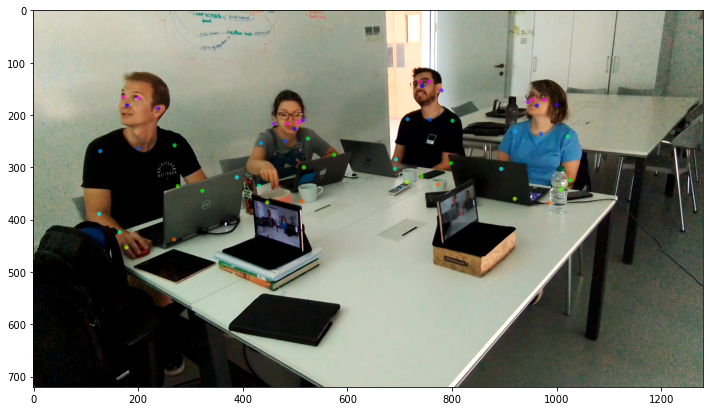

In [101]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)